In [209]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


random.seed(5) #for reproducability
chunk_size = 256 #configure as needed

In [211]:
def Linear_Scale(dataframe, column): #normal absolute max normalization
    dataframe[column] = (dataframe[column] - dataframe[column].min()) / (dataframe[column].max() - dataframe[column].min())
    
def Z_norm(dataframe, column): #see z-score normalization, better for outlier detection
    dataframe[column] = (dataframe[column] - dataframe[column].mean()) / dataframe[column].std()

def dfsplitter(dflist):
    percent70 = int(len(dflist) * 0.7)
    percent20 = int(len(dflist) * 0.2)
    
    first70 = dflist[0 : percent70]
    next20 = dflist[percent70 : percent70 + percent20]
    last10 = dflist[percent70 + percent20 : ]
    return(first70, next20, last10)

def combine_and_shuffle(list1, list2):
    dflist = list1 + list2
    random.shuffle(dflist)
    return pd.concat(dflist, ignore_index=True)

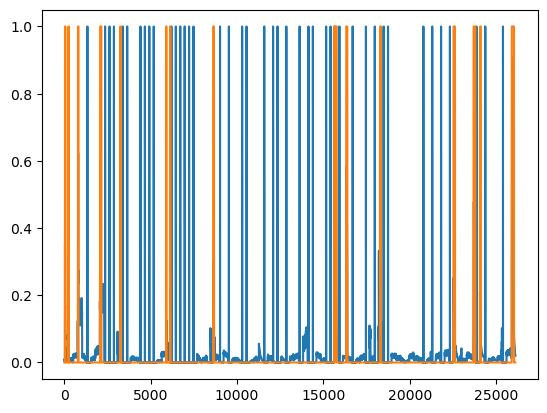

In [213]:
random.seed(5)

df = pd.read_csv('processed.csv', chunksize=chunk_size, iterator=True) #df is now a TextFileReader dtype
allchunks = [pd.DataFrame(chunk) for chunk in df]
random.shuffle(allchunks)

empty = pd.read_csv('empty.csv', chunksize=chunk_size, iterator=True)
allempties = []

for chunk in empty:
    chunk.loc[chunk.sample(frac=0.004, random_state=2).index, columns_for_train] = 5996
    for column in columns_for_train:
        Z_norm(chunk, column)
        Linear_Scale(chunk, column)
    allempties.append(pd.DataFrame(chunk))


first70, next20, last10 = dfsplitter(allchunks)
empty70, empty20, empty10 = dfsplitter(allempties)

final70 = combine_and_shuffle(first70, empty70)
final20 = combine_and_shuffle(next20, empty20)
final10 = combine_and_shuffle(last10, empty10)
plt.plot(final70.index[:], final70['1.0 std'][:], final70['Fire'][:])

In [29]:
#reshaping dataframe, pull X and y
columns_for_train = ['1.0 std','2.5 std', '10 std'] #choose what to train on

X = sdf.loc[:, columns_for_train] #dataframe with only these columns
y = sdf.loc[:, ['Fire']] #dataframe for output

X, y = X.to_numpy(), y.to_numpy() #convert to numpy arrays

y = y.flatten() #reshaping each
X = X.reshape((X.shape[0], X.shape[1], 1))

print(len(X))

21735


In [31]:
#split into train, validation, and test for X and y


train_size = int(len(allchunks)*0.7) * chunk_size #70% of data, ensures a chunk wont get broken up during train/val/test split
val_size = int(len(allchunks)*0.2) * chunk_size #20%
#test data is just the rest (not exactly 10% due to rounding)


X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15104, 3, 1), (15104,), (4352, 3, 1), (4352,), (2279, 3, 1), (2279,))

In [33]:
model = keras.Sequential()
model.add(keras.Input(shape=(3, 1))) #no specific amount of timesteps, 3 pixels in each row/timestep
model.add(layers.GRU(512, return_sequences=True, activation='relu')) #returns the output of each timestep so we can stack multiple RNN layers
model.add(layers.GRU(256, activation='relu')) #no return sequences so that normal dense layers can proceed it
model.add(layers.Dense(2))

#could do LSTM, GRU, or RNN and can change by literally just swapping them out

print(model.summary())

#RNNs typically use tanh instead of relu

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #fromlogits is true since we don't have softmax activation in final dense layer
    optimizer=keras.optimizers.Adam(learning_rate=0.001), #dont make learning rate too high or will result in overfitment of training data
    metrics=['accuracy']
)

model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val),epochs=10, verbose=1)

model.evaluate(X_test, y_test, batch_size=32, verbose=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 3, 512)         │       791,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,382,914 (5.28 MB)

 Trainable params: 1,382,914 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9447 - loss: 0.1766 - val_accuracy: 0.9933 - val_loss: 0.0205
Epoch 2/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9697 - loss: 0.0783 - val_accuracy: 0.9929 - val_loss: 0.0207
Epoch 3/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9724 - loss: 0.0716 - val_accuracy: 0.9936 - val_loss: 0.0182
Epoch 4/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9764 - loss: 0.0640 - val_accuracy: 0.9943 - val_loss: 0.0176
Epoch 5/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9775 - loss: 0.0612 - val_accuracy: 0.9936 - val_loss: 0.0193
Epoch 6/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9727 - loss: 0.0692 - val_accuracy: 0.9920 - val_loss: 0.0171
Epoch 7/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9782 - loss: 0.0558 - val_accuracy: 0.9920 - val_loss: 0.0162
Epoch 8/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9773 - loss: 0.05

[0.04499903321266174, 0.9780605435371399]